In [282]:
!pip install xgboost lightgbm catboost

In [283]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
train = pd.read_csv('Titanic.csv')
test = pd.read_csv('test.csv')

Посмотрим на данные

In [284]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [285]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Таблица имеет мнформацию о 891 пассажире.  
12 столбцов:  
0 - id - нет пропусков;  
1 - выжил (1) или нет (0) - нет пропусков;  
2 - класс билета - 1-3 - пропусков нет;  
3 - имя - пропусков нет;  
4 - пол - пропусков нет;  
5 - возраст - 177 пропусков;  
6 - количесво братьев, сестер, супруг на борту - нет пропусков;  
7 - количесво родителей и детей на борту - нет пропусков;  
8 - номер билета - нет пропусков;  
9 - стоимость билета - нет пропусков;  
10 - каюта - 687 пропусков;  
11 - порт посадки - 2 пропуска;  
  
Можно сделать выводы о том, что не выжило около 62% пассажиров, большинство пассажиров из 2 и 3 класса.

In [286]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Посмотрим как от некоторых признаков зависит выживаемость

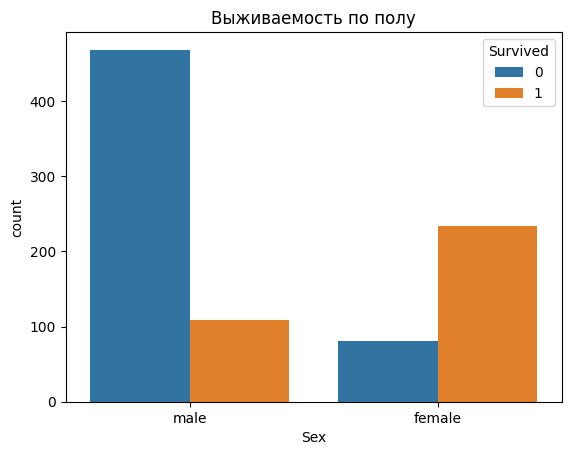

In [287]:
sns.countplot(data=train, x='Sex', hue='Survived')
plt.title('Выживаемость по полу')
plt.show()

По графику можно сделать вывод, что процент выживших женщин был выше, чем процент выживших мужчин.

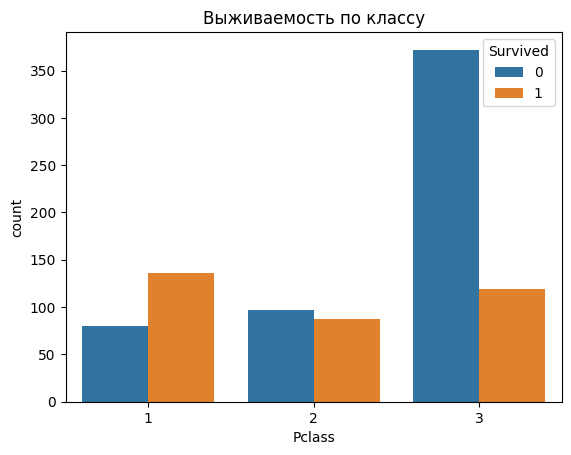

In [288]:
sns.countplot(data=train, x='Pclass', hue='Survived')
plt.title('Выживаемость по классу')
plt.show()

По графику можно сделать вывод, что процент выживших в первом и втором классе каюты был выше, чем процент выживших в третьем классе.

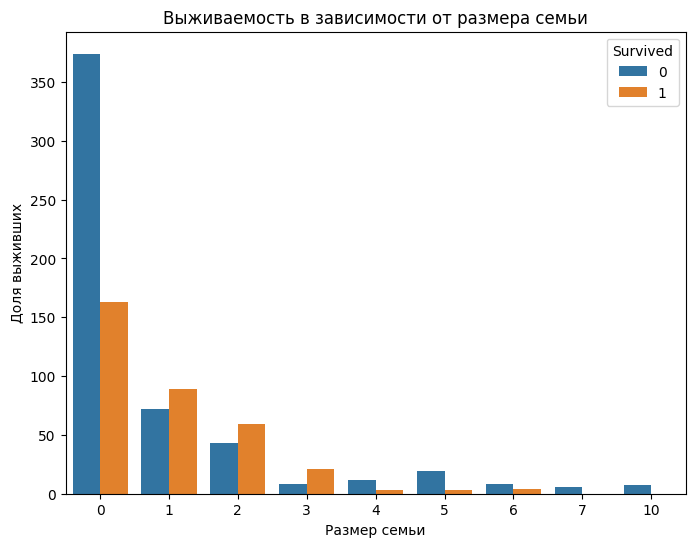

In [289]:
plt.figure(figsize=(8, 6))
sns.countplot(x=train['SibSp']+train['Parch'], hue='Survived', data=train)
plt.title('Выживаемость в зависимости от размера семьи')
plt.xlabel('Размер семьи')
plt.ylabel('Доля выживших')
plt.show()

По графику можно сделать вывод, что пассажиры, путешествующие в одиночку, имели меньшие шансы на выживание по сравнению с теми, у кого были небольшие семьи (2-4 человека). Очень большие семьи (5+ человек) также имели низкие шансы на выживание.

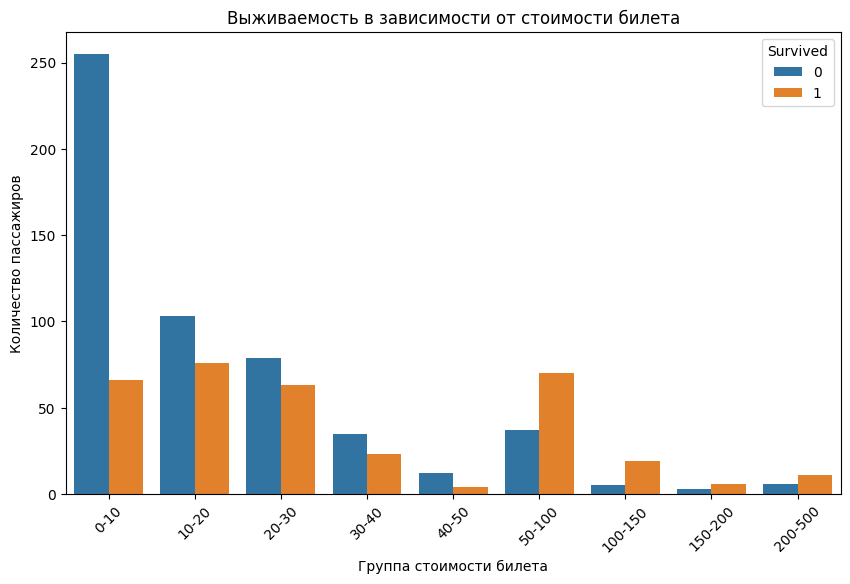

In [290]:
bins = [0, 10, 20, 30, 40, 50, 100, 150, 200, 500]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-100', '100-150', '150-200', '200-500']

fareGroup = pd.cut(train['Fare'], bins=bins, labels=labels)

plt.figure(figsize=(10, 6))
sns.countplot(data=train, x=fareGroup, hue='Survived')
plt.title('Выживаемость в зависимости от стоимости билета')
plt.xlabel('Группа стоимости билета')
plt.ylabel('Количество пассажиров')
plt.xticks(rotation=45)
plt.show()

По графику можно сделать вывод, что  процент выживших стал превышать процент умерших при стоймсоти билета свыше 50 доларов.

<ipython-input-291-d8ae105d5474>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_bin_survival = train.groupby('AgeBin')['Survived'].mean() * 100


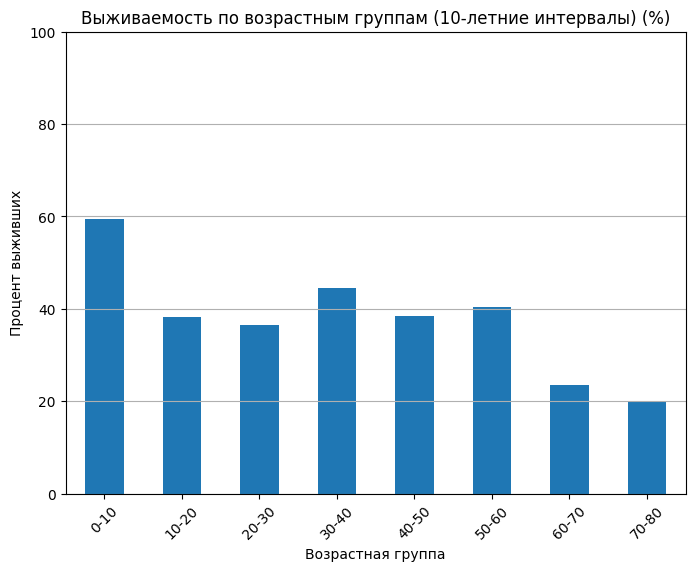

In [291]:
labels_age = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80']
train['AgeBin'] = pd.cut(train['Age'], bins=range(0, 90, 10),labels=labels_age)
age_bin_survival = train.groupby('AgeBin')['Survived'].mean() * 100
train = train.drop('AgeBin',axis = 1)
plt.figure(figsize=(8, 6))
age_bin_survival.plot(kind='bar')
plt.title('Выживаемость по возрастным группам (10-летние интервалы) (%)')
plt.xlabel('Возрастная группа')
plt.ylabel('Процент выживших')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show()

По графику можно сделать вывод, что дети имели значительно большие шансы на выживание.

Объединим test и train данные для удобного feature engineering

In [292]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [293]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [294]:
train['TrainFlag'] = 1
test['TrainFlag'] = 0
test['Survived'] = np.nan
full_data = pd.concat([train, test], sort=False).reset_index(drop=True)

Уберем пропуски и добавим несколько новых признаков:

Family - количество родственников на корабле(включая самого себя)

IsAlone - признак, показывающий есть ли родственники на корабле

Title - Приставка перед именем человека (Mr, Miss, Mrs)

CabinDeck - Часть корабля в которой находится каюта пассажира


In [295]:
full_data['Age'] = full_data['Age'].fillna(full_data.groupby('Pclass')['Age'].transform('median'))
full_data['Fare'] = full_data['Fare'].fillna(full_data['Fare'].median())
full_data['Embarked'] = full_data['Embarked'].fillna(full_data['Embarked'].mode()[0])
full_data['FamilySize'] = full_data['SibSp'] + full_data['Parch'] + 1
full_data['IsAlone'] = (full_data['FamilySize'] == 1).astype(int)
full_data['Title'] = full_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
full_data['Cabin'] = full_data['Cabin'].fillna('U') # заменим неизвестные типы кабин на U
full_data['CabinDeck'] = full_data['Cabin'].apply(lambda x: x[0])
full_data['FareGroup'] = pd.cut(full_data['Fare'], bins=bins, labels=labels, right=False)
full_data['AgeBin'] = pd.cut(full_data['Age'], bins=range(0, 90, 10),labels=labels_age)

title_counts = full_data['Title'].value_counts()
title_counts

,count
Title,
Mr,757
Miss,260
Mrs,197
Master,61
Rev,8
Dr,8
Col,4
Major,2
Mlle,2


Заменим редкие приставки перед именами на Rare

In [296]:
full_data['Title'] = full_data['Title'].replace(title_counts[title_counts < 50].index, 'Rare')
full_data['Embarked'] = full_data['Embarked'].astype(str)
full_data['Title'] = full_data['Title'].astype(str)
full_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TrainFlag,FamilySize,IsAlone,Title,CabinDeck,FareGroup,AgeBin
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,1,2,0,Mr,U,0-10,20-30
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,2,0,Mrs,C,50-100,30-40
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,1,1,1,Miss,U,0-10,20-30
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,2,0,Mrs,C,50-100,30-40
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,1,1,1,Mr,U,0-10,30-40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,24.0,0,0,A.5. 3236,8.0500,U,S,0,1,1,Mr,U,0-10,20-30
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,0,1,1,Rare,C,100-150,30-40
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,U,S,0,1,1,Mr,U,0-10,30-40
1307,1308,NaN,3,"Ware, Mr. Frederick",male,24.0,0,0,359309,8.0500,U,S,0,1,1,Mr,U,0-10,20-30


In [297]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1309 non-null   int64   
 1   Survived     891 non-null    float64 
 2   Pclass       1309 non-null   int64   
 3   Name         1309 non-null   object  
 4   Sex          1309 non-null   object  
 5   Age          1309 non-null   float64 
 6   SibSp        1309 non-null   int64   
 7   Parch        1309 non-null   int64   
 8   Ticket       1309 non-null   object  
 9   Fare         1309 non-null   float64 
 10  Cabin        1309 non-null   object  
 11  Embarked     1309 non-null   object  
 12  TrainFlag    1309 non-null   int64   
 13  FamilySize   1309 non-null   int64   
 14  IsAlone      1309 non-null   int64   
 15  Title        1309 non-null   object  
 16  CabinDeck    1309 non-null   object  
 17  FareGroup    1305 non-null   category
 18  AgeBin       1309 non-null  

Выделим числовые и категориальные признаки

In [298]:
numeric_features = ['Age', 'Fare', 'FamilySize']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'IsAlone', 'Title']

Разделим данные обратно после feature engineering

Выведем получившийся X_train и X_test

In [299]:
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'IsAlone', 'Title','CabinDeck','FareGroup','AgeBin']
X_all = full_data[features]
X_train = X_all[full_data['TrainFlag'] == 1]
X_test = X_all[full_data['TrainFlag'] == 0].reset_index().drop('index', axis=1)
X_train['Survived'] = full_data.loc[full_data['TrainFlag'] == 1, 'Survived'].astype(int)
X_train

<ipython-input-299-1dddf5551bf5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Survived'] = full_data.loc[full_data['TrainFlag'] == 1, 'Survived'].astype(int)


,Pclass,Sex,Age,Fare,Embarked,FamilySize,IsAlone,Title,CabinDeck,FareGroup,AgeBin,Survived
0,3,male,22.0,7.2500,S,2,0,Mr,U,0-10,20-30,0
1,1,female,38.0,71.2833,C,2,0,Mrs,C,50-100,30-40,1
2,3,female,26.0,7.9250,S,1,1,Miss,U,0-10,20-30,1
3,1,female,35.0,53.1000,S,2,0,Mrs,C,50-100,30-40,1
4,3,male,35.0,8.0500,S,1,1,Mr,U,0-10,30-40,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,male,27.0,13.0000,S,1,1,Rare,U,10-20,20-30,0
887,1,female,19.0,30.0000,S,1,1,Miss,B,30-40,10-20,1
888,3,female,24.0,23.4500,S,4,0,Miss,U,20-30,20-30,0
889,1,male,26.0,30.0000,C,1,1,Mr,C,30-40,20-30,1


In [300]:
X_test

,Pclass,Sex,Age,Fare,Embarked,FamilySize,IsAlone,Title,CabinDeck,FareGroup,AgeBin
0,3,male,34.5,7.8292,Q,1,1,Mr,U,0-10,30-40
1,3,female,47.0,7.0000,S,2,0,Mrs,U,0-10,40-50
2,2,male,62.0,9.6875,Q,1,1,Mr,U,0-10,60-70
3,3,male,27.0,8.6625,S,1,1,Mr,U,0-10,20-30
4,3,female,22.0,12.2875,S,3,0,Mrs,U,10-20,20-30
...,...,...,...,...,...,...,...,...,...,...,...
413,3,male,24.0,8.0500,S,1,1,Mr,U,0-10,20-30
414,1,female,39.0,108.9000,C,1,1,Rare,C,100-150,30-40
415,3,male,38.5,7.2500,S,1,1,Mr,U,0-10,30-40
416,3,male,24.0,8.0500,S,1,1,Mr,U,0-10,20-30


Выведем гистограммы по всем признакам

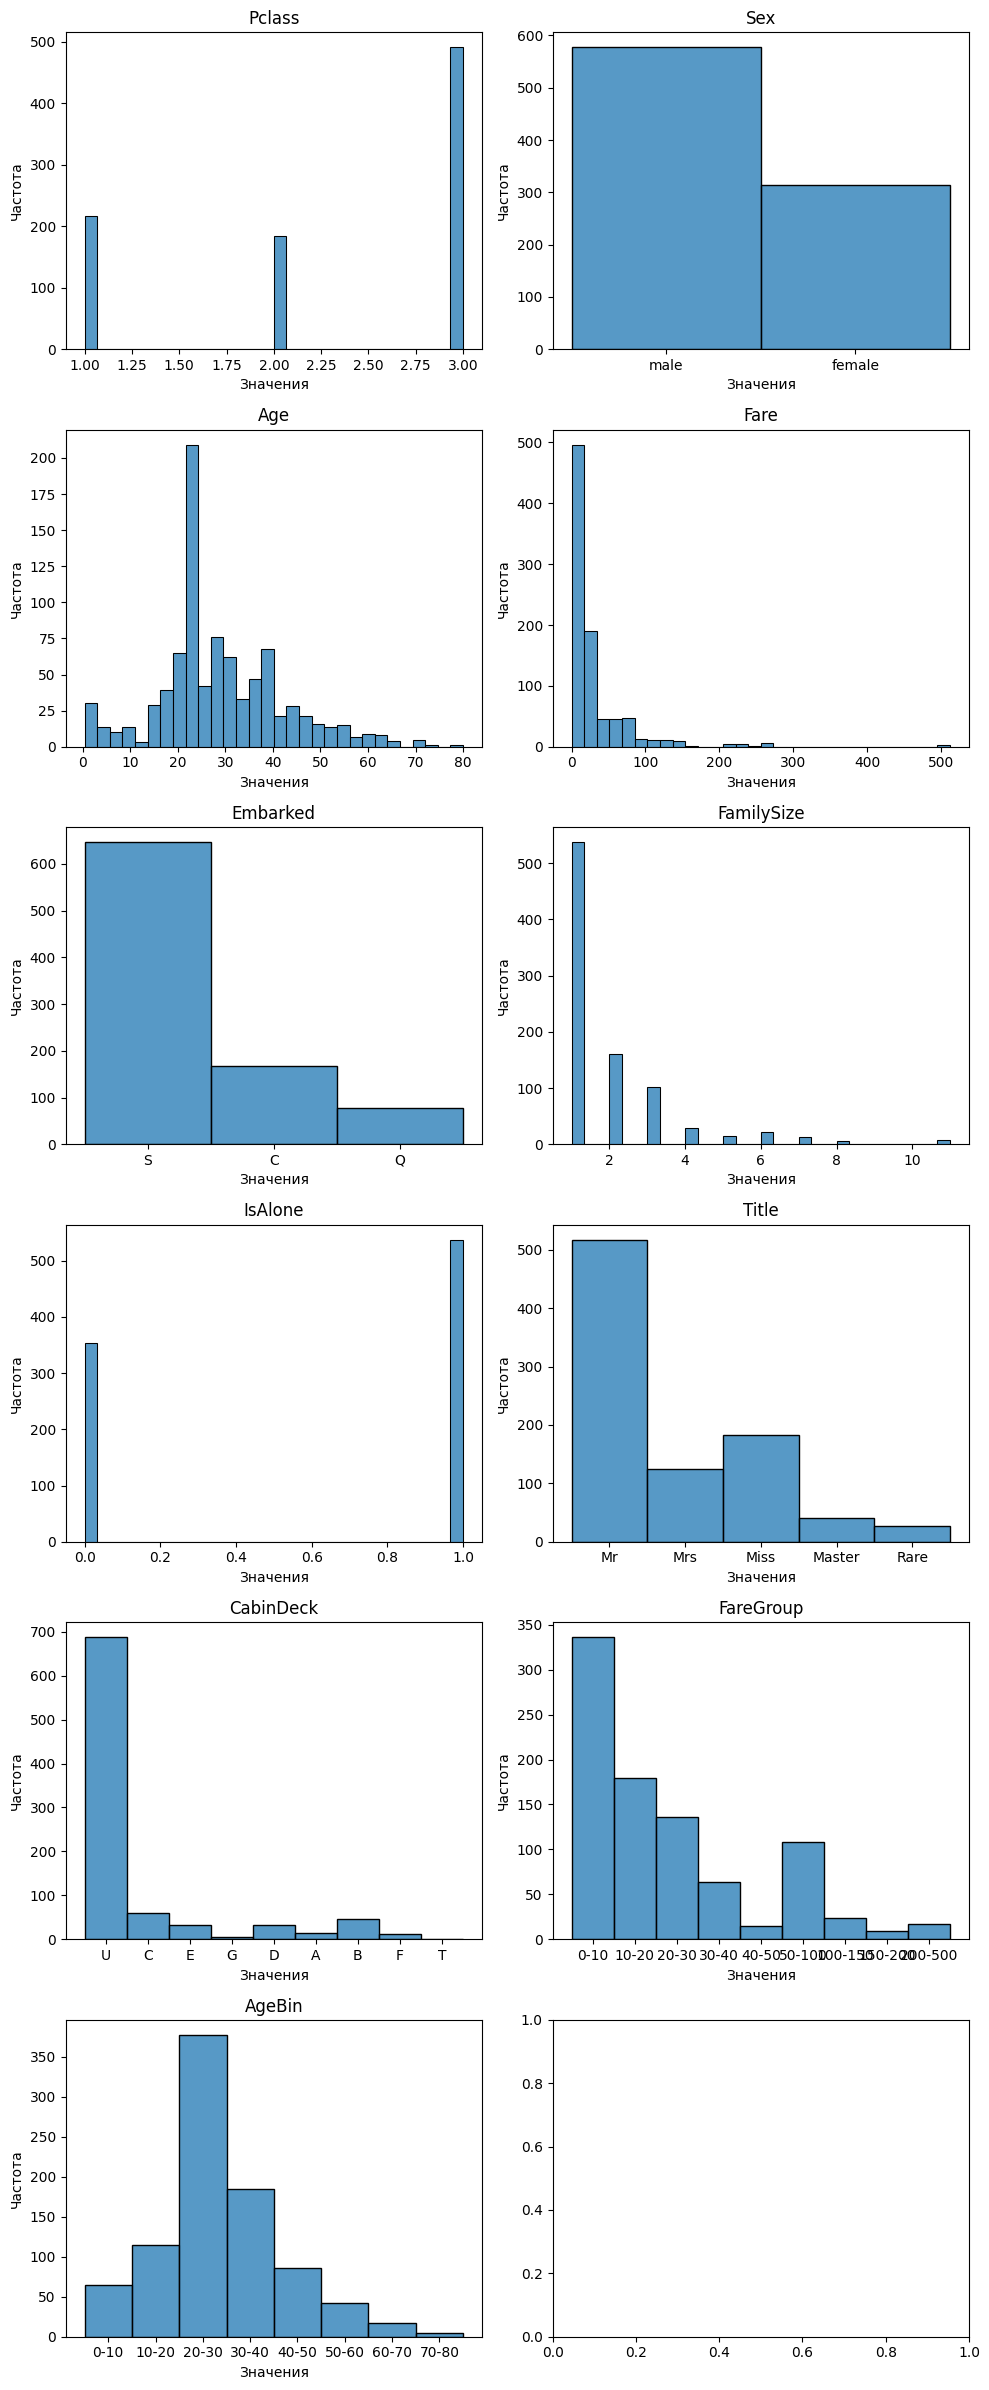

In [301]:
width = 2
height = int(np.ceil(len(features) / width))

fig, axes = plt.subplots(nrows=height, ncols=width, figsize=(10, 4 * height))
axes = axes.flatten()

for idx, column in enumerate(features):
    sns.histplot(data=X_train, x=column, bins=30, ax=axes[idx])
    axes[idx].set_title(column)
    axes[idx].set_xlabel('Значения')
    axes[idx].set_ylabel('Частота')

plt.tight_layout()
plt.show()

Age,AgeBin имеет нормальное распределение, Fare, FamilySize имеют экспоненциальное распределения

Стандартизируем числовые признаки и закодируем категориальные для X_train

In [302]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore',sparse_output=False), categorical_features)
    ]
)

In [303]:
y = X_train["Survived"]

X_train_transformed = preprocessor.fit_transform(X_train)
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])
X_train_transformed = pd.DataFrame(X_train_transformed, columns=all_feature_names)
X_train_transformed

,Age,Fare,FamilySize,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,IsAlone_0,IsAlone_1,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,-0.537087,-0.502445,0.059160,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.667524,0.786845,0.059160,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.235934,-0.488854,-0.560975,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.441659,0.420730,0.059160,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.441659,-0.486337,-0.560975,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,-0.160646,-0.386671,-0.560975,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
887,-0.762952,-0.044381,-0.560975,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
888,-0.386511,-0.176263,1.299429,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
889,-0.235934,-0.044381,-0.560975,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


То же самое сделаем для X_test

In [306]:
X_test_transformed = preprocessor.transform(X_test)
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])
X_test_transformed = pd.DataFrame(X_test_transformed, columns=all_feature_names)
X_test_transformed

,Age,Fare,FamilySize,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,IsAlone_0,IsAlone_1,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0.404015,-0.490783,-0.560975,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.345118,-0.507479,0.059160,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.474441,-0.453367,-0.560975,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,-0.160646,-0.474005,-0.560975,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,-0.537087,-0.401017,0.679295,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,-0.386511,-0.486337,-0.560975,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
414,0.742812,1.544246,-0.560975,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
415,0.705168,-0.502445,-0.560975,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
416,-0.386511,-0.486337,-0.560975,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


Выведем корреляционную матрицу для всех признаков

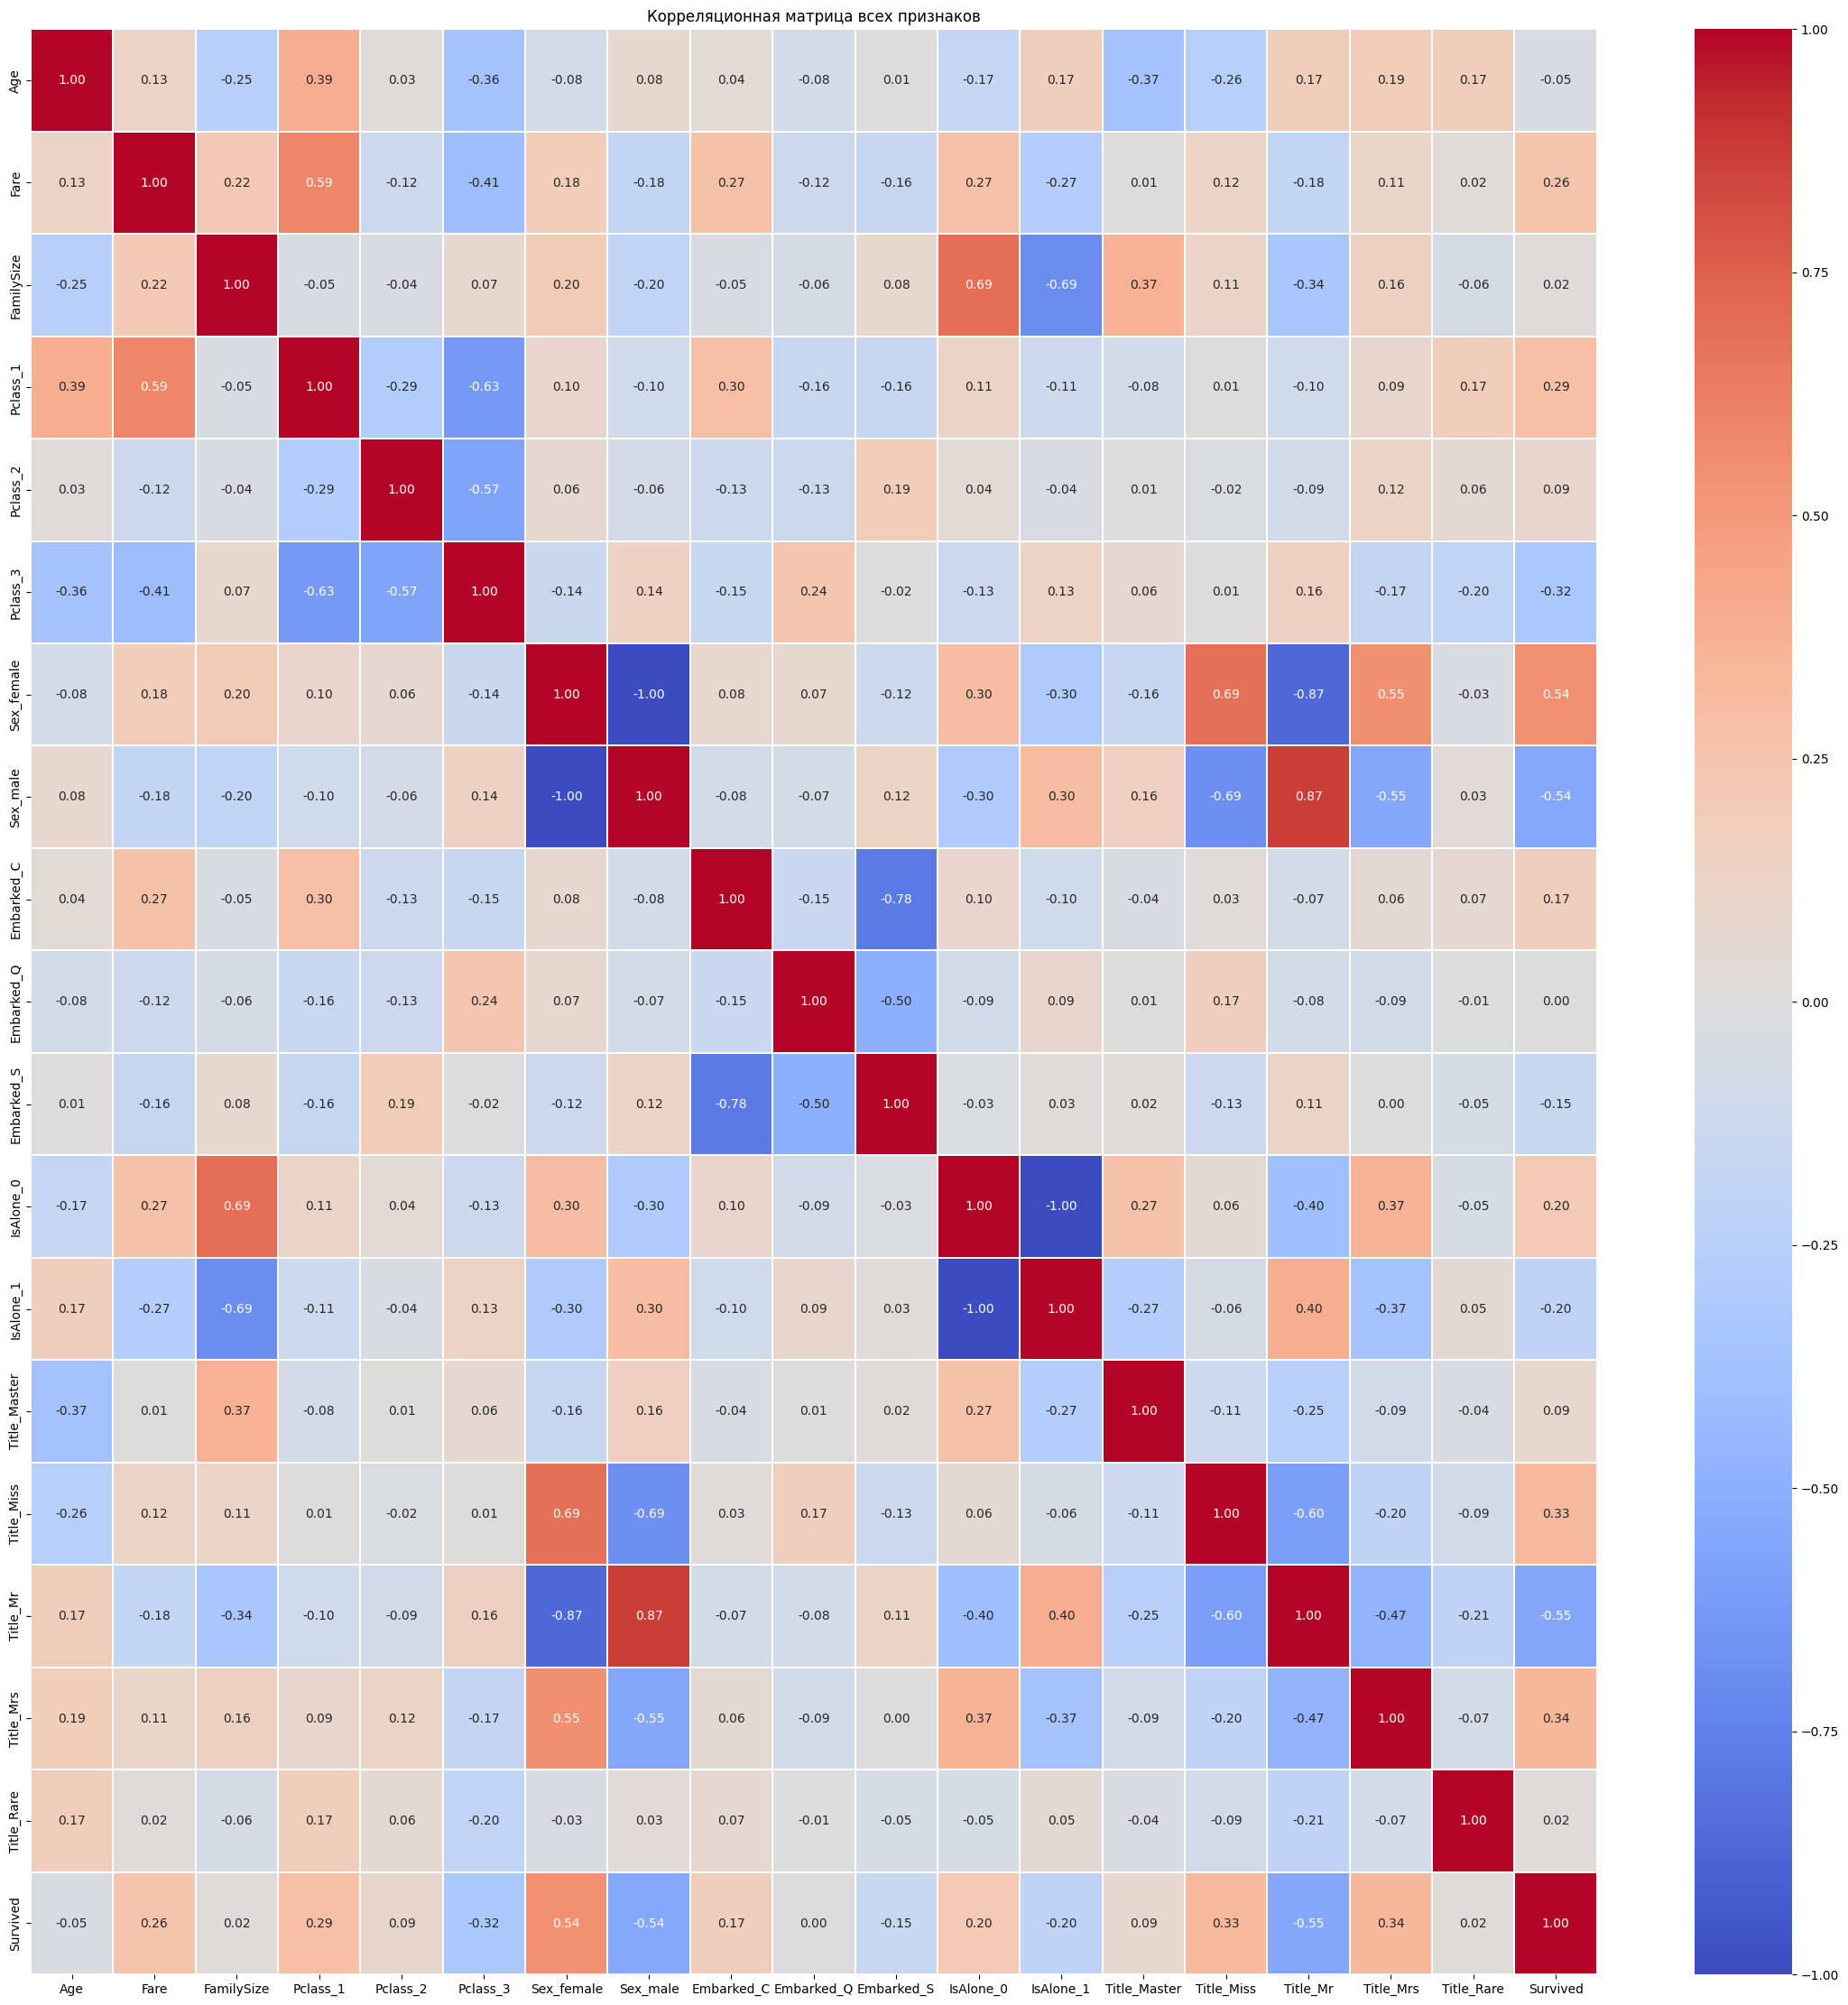

In [308]:
corr_matrix = X_train_transformed.corr()

plt.figure(figsize=(28, 28))
sns.heatmap(corr_matrix,  cmap='coolwarm', linewidths=0.1,annot=True,fmt='.2f')
plt.title('Корреляционная матрица всех признаков')
plt.show()


Основные корреляции с target('Survived')

Sex_female 0.54 - женщин выжило больше, чем мужчин (для Sex_male корреляция -0.54)

Fare - чем дороже билет, тем выше вероятность выживания

Pclass1 - чем выше класс каюты, тем выше вероятность выживания (для Pclass3 корреляция -0.32)

Title_Miss и Title_Mrs 0.33 и 0.34 - так как сильная корреляция с полом, то и здесь тоже (для Title_Mr -0.55)

Embarked_C - те кто сели на Титаник в Cherbourg с большей вероятностью выжили

IsAlone0 - 0.20 те у кого на корабле были родственики с большей вероятностью выжили

Также есть слабые корреляции с расположением каюты

Выведем отдельно значения всех корреляций с target

In [309]:

surv_corr = X_train_transformed.corr()['Survived'].sort_values(ascending=False).drop('Survived', axis=0)

print(" Корреляция признаков с выживанием:")
X_train_transformed = X_train_transformed.drop('Survived', axis=1)
surv_corr

 Корреляция признаков с выживанием:


,Survived
Sex_female,0.543351
Title_Mrs,0.339040
Title_Miss,0.327093
Pclass_1,0.285904
Fare,0.257307
IsAlone_0,0.203367
Embarked_C,0.168240
Pclass_2,0.093349
Title_Master,0.085221
Title_Rare,0.022030


Разделим данные на тренирововчную и на валидационную выборки

In [310]:
X_train_, X_val_, y_train_, y_val = train_test_split(
     X_train_transformed, y, test_size=0.2, stratify=y, random_state=42
)

Создадим несколько моделей и варианты параметров

In [348]:
models = [
    ("LogisticRegression", LogisticRegression(max_iter=1000,random_state=42, solver='liblinear')),
    ("RandomForest", RandomForestClassifier(n_estimators=100, random_state=42,max_depth=8)),
    ("GradientBoosting", GradientBoostingClassifier(n_estimators=100, random_state=42,max_depth=4)),
    ("SVC", SVC(probability=True,random_state=42)),
    ("KNN", KNeighborsClassifier(n_neighbors=5)),
    ("LightGBM", LGBMClassifier(random_state=42, verbose=-1)),
    ("CatBoost", CatBoostClassifier(random_state=42, verbose=0)),
    ("XGBoost", XGBClassifier(colsample_bylevel= 0.7, colsample_bytree= 0.8, learning_rate= 0.05, max_depth= 5, min_child_weight= 5, n_estimators= 200, scale_pos_weight= 1, subsample= 0.8 )),
]


In [360]:
param_grids = {
    "LogisticRegression": {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga'],
        'penalty': ['l2', 'elasticnet'],
        'max_iter': [100, 500, 1000],
        'tol': [1e-4, 1e-3, 1e-2],
    },
    "RandomForest": {
        'n_estimators': [100, 200, 500],
        'max_depth': [4,6, 8, 12],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    },
    "GradientBoosting": {
        'n_estimators': [100, 200],
        'max_depth': [3, 4, 5,],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'min_samples_split': [2,3,4],
        'min_samples_leaf': [1, 2],
    },
    "SVC": {
        'C': [0.01, 0.1, 1],
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto', 0.1],
        'degree': [2, 3, 4],
        'class_weight': ['balanced', None],
    },
    "KNN": {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'euclidean', 'manhattan'],
        'leaf_size': [20, 30, 40],
        'algorithm': ['auto', 'ball_tree', 'kd_tree'],
    },
    "LightGBM": {
        'n_estimators': [100, 300],
        'num_leaves': [31, 63],
        'learning_rate': [0.05, 0.1],
        'feature_fraction': [0.9, 1.0],
        'bagging_fraction': [0.8, 1.0],
        'bagging_freq': [1],
        'max_depth': [-1, 8],
        'min_child_samples': [20, 50]
    },
     "CatBoost": {
        'iterations': [300, 500],
        'learning_rate': [0.05, 0.1],
        'depth': [6, 8],
        'l2_leaf_reg': [3, 10],
        'subsample': [0.8, 1.0]
    },
    "XGBoost": {
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200],
        'max_depth': [4,5],
        'min_child_weight': [1, 3, 5, 7],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.7,0.8],
        'colsample_bylevel': [0.7],
        'scale_pos_weight': [1, 2],
    },
}

Для каждой модели используем GridSearchCV и StratifiedKFold для поиска лучших параметров по метрике accuracy(Потому что такая в соревновании на kaggle)

Для каждой модели выведем лучшие подобранные параметры

In [361]:
results = {}
for name, model in models:
    print(f"Ищем лучшие параметры для модели: {name}")

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train_, y_train_)

    best_score = grid_search.best_score_
    best_params = grid_search.best_params_

    results[name] = best_score
    print(f"{name}: Accuracy = {best_score:.4f} (Лучшие параметры: {best_params})\n")

best_model_name = max(results, key=results.get)

print(f"\n Лучшая модель: {best_model_name}")


Ищем лучшие параметры для модели: LogisticRegression
Fitting 5 folds for each of 180 candidates, totalling 900 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
450 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
225 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_sol

LogisticRegression: Accuracy = 0.8217 (Лучшие параметры: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.0001})

Ищем лучшие параметры для модели: RandomForest
Fitting 5 folds for each of 108 candidates, totalling 540 fits
RandomForest: Accuracy = 0.8287 (Лучшие параметры: {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500})

Ищем лучшие параметры для модели: GradientBoosting
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
GradientBoosting: Accuracy = 0.8302 (Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 200, 'subsample': 0.9})

Ищем лучшие параметры для модели: SVC
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
SVC: Accuracy = 0.8315 (Лучшие параметры: {'C': 1, 'class_weight': None, 'degree': 4, 'gamma': 0.1, 'kernel': 'poly'})

Ищем лучшие параметры для модели: KNN
Fitting 5 folds for each of 216 candidates, totalling 1080

В итоге лучшая модель SVC

 Accuracy = 0.8315 (Лучшие параметры: {'C': 1, 'class_weight': None, 'degree': 4, 'gamma': 0.1, 'kernel': 'poly'})

In [362]:
best_model = SVC(C= 1, class_weight= None, degree= 4, gamma= 0.1, kernel= 'poly' )
best_model.fit(
    X_train_, y_train_,
)
predictions = best_model.predict(X_test_transformed)

Посмотрим есть ли переобучение на X_val_

In [364]:
from sklearn.metrics import accuracy_score, roc_auc_score
predictions_val = best_model.predict(X_val_)
print(f"Train accuracy: {accuracy_score(y_val, predictions_val):.4f}")

Train accuracy: 0.8324


Так как accuracy на X_train_transformed и X_val_ примерно одинаковы, то переобучения нет

Создаем result для сабмита

In [365]:
result = pd.DataFrame(test['PassengerId'])
result['Survived'] = predictions
result

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


Сохраним в predictions

In [366]:
result.to_csv("predictions.csv", index=False)